## Geneformer Fine-Tuning for Classification of Cardiomyopathy Disease States

### Please note that, as usual with deep learning models, we **highly** recommend tuning learning hyperparameters for all fine-tuning applications as this can significantly improve model performance. Example below uses previously optimized hyperparameters, but one can optimize hyperparameters with the argument n_hyperopt_trials=n in cc.validate() where n>0 and represents the number of trials for hyperparameter optimization.

### Train cell classifier with 70% of data (with hyperparameters previously optimized based on 15% of data as validation set) and evaluate on held-out test set of 15% of data

### Fine-tune the model for cell state classification

In [1]:
# !pip install transformers[torch]
# !pip install accelerate -U

In [2]:
!nvidia-smi

import torch
torch.cuda.empty_cache()

Sun Jun  2 02:19:10 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.76                 Driver Version: 550.76         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti     On  |   00000000:3D:00.0 Off |                  N/A |
|  0%   30C    P8              1W /  180W |       1MiB /  11264MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
import sys
if '/part-vol-2/weaver-core/particle_transformer_quant/notebooks/Fun_Gen/Geneformer' not in sys.path:
    sys.path.append('/part-vol-2/weaver-core/particle_transformer_quant/notebooks/Fun_Gen/Geneformer')

In [7]:
from geneformer import Classifier

AttributeError: partially initialized module 'pandas' has no attribute 'core' (most likely due to a circular import)

In [4]:
import datetime
from geneformer import Classifier

current_date = datetime.datetime.now()
datestamp = f"{str(current_date.year)[-2:]}{current_date.month:02d}{current_date.day:02d}{current_date.hour:02d}{current_date.minute:02d}{current_date.second:02d}"
datestamp_min = f"{str(current_date.year)[-2:]}{current_date.month:02d}{current_date.day:02d}"

output_prefix = "cm_classifier_test" 
output_dir = f"/part-vol-2/weaver-core/particle_transformer_quant/notebooks/Fun_Gen/output_directory_cell_class_pancreas/{datestamp}"
!mkdir $output_dir

/part-vol-2/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
filter_data_dict={"cell_type":["Cardiomyocyte1","Cardiomyocyte2","Cardiomyocyte3"]}
training_args = {
    "num_train_epochs": 0.6,        # me changed to 0.1 from 0.9
    "learning_rate": 0.000804,
    "lr_scheduler_type": "polynomial",
    "warmup_steps": 1812,
    "weight_decay":0.258828,
    "per_device_train_batch_size": 4,   # me changed to 4 from 12
    "seed": 73,
}
cc = Classifier(classifier="cell",
                cell_state_dict =  {"state_key": "cell_type", "states": "all"},             #{"state_key": "disease", "states": "all"},
                filter_data=None, # filter_data_dict,
                training_args=training_args,
                max_ncells=None,
                freeze_layers = 5,           # me changed to 5 from 2 
                num_crossval_splits = 1,
                forward_batch_size=64,      # me changed to 4 from 200
                nproc=8)

In [6]:
# previously balanced splits with prepare_data and validate functions
# argument attr_to_split set to "individual" and attr_to_balance set to ["disease","lvef","age","sex","length"]
train_ids = ["1447", "1600", "1462", "1558", "1300", "1508", "1358", "1678", "1561", "1304", "1610", "1430", "1472", "1707", "1726", "1504", "1425", "1617", "1631", "1735", "1582", "1722", "1622", "1630", "1290", "1479", "1371", "1549", "1515"]
eval_ids = ["1422", "1510", "1539", "1606", "1702"]
test_ids = ["1437", "1516", "1602", "1685", "1718"]

train_test_id_split_dict = {"attr_key": "individual",
                            "train": train_ids+eval_ids,
                            "test": test_ids}

# Example input_data_file: https://huggingface.co/datasets/ctheodoris/Genecorpus-30M/tree/main/example_input_files/cell_classification/disease_classification/human_dcm_hcm_nf.dataset
cc.prepare_data(input_data_file="/part-vol-2/weaver-core/particle_transformer_quant/notebooks/Fun_Gen/Data/Genecorpus-30M/Pancreas/data/datasets/geneformer/pancreas_scib/pancreas_scib.dataset",
                output_directory=output_dir,
                output_prefix=output_prefix,
                split_id_dict=None) # me train_test_id_split_dict)

Saving the dataset (1/1 shards): 100%|██████████| 1639/1639 [00:00<00:00, 77271.56 examples/s]


In [8]:
train_valid_id_split_dict = {"attr_key": "individual",
                            "train": train_ids,
                            "eval": eval_ids}
print('completed training!')
# 6 layer Geneformer: https://huggingface.co/ctheodoris/Geneformer/blob/main/model.safetensors
all_metrics = cc.validate(model_directory="/part-vol-2/weaver-core/particle_transformer_quant/notebooks/Fun_Gen/Geneformer",
                          prepared_input_data_file=f"{output_dir}/{output_prefix}_labeled_train.dataset",
                          id_class_dict_file=f"{output_dir}/{output_prefix}_id_class_dict.pkl",
                          output_directory=output_dir,
                          output_prefix=output_prefix,
                          split_id_dict=None) # train_valid_id_split_dict)
                          # to optimize hyperparameters, set n_hyperopt_trials=100 (or alternative desired # of trials)

mkdir: cannot create directory ‘/part-vol-2/weaver-core/particle_transformer_quant/notebooks/Fun_Gen/output_directory_cell_class_pancreas/240602021923/240602_geneformer_cellClassifier_cm_classifier_test/’: File exists


completed training!


  0%|          | 0/1 [00:00<?, ?it/s]

****** Validation split: 1/1 ******



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /part-vol-2/weaver-core/particle_transformer_quant/notebooks/Fun_Gen/Geneformer and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/part-vol-2/.venv/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
/part-vol-2/weaver-core/particle_transformer_quant/notebooks/Fun_Gen/Geneformer/geneformer/collator_for_classification.py:581: UserWarning: To copy construct from a te

Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
0,0.764500,0.478534,0.854790,0.583533


100%|██████████| 1/1 [03:31<00:00, 211.41s/it]


In [9]:
!nvidia-smi

Sun Jun  2 02:23:47 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.76                 Driver Version: 550.76         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti     On  |   00000000:3D:00.0 Off |                  N/A |
|  0%   47C    P2             50W /  180W |    5085MiB /  11264MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [10]:

# import torch
# torch.cuda.empty_cache()

### Evaluate the model

In [11]:
cc = Classifier(classifier="cell",
                cell_state_dict = {"state_key": "disease", "states": "all"},     # change disease?
                forward_batch_size=64,
                nproc=8)

Hyperparameter tuning is highly recommended for optimal results. No training_args provided; using default hyperparameters.


In [12]:
all_metrics_test = cc.evaluate_saved_model(
        model_directory=f"{output_dir}/{datestamp_min}_geneformer_cellClassifier_{output_prefix}/ksplit1/",
        id_class_dict_file=f"{output_dir}/{output_prefix}_id_class_dict.pkl",
        test_data_file=f"{output_dir}/{output_prefix}_labeled_test.dataset",
        output_directory=output_dir,
        output_prefix=output_prefix,
    )

100%|██████████| 26/26 [00:36<00:00,  1.40s/it]


<Figure size 1000x1000 with 0 Axes>

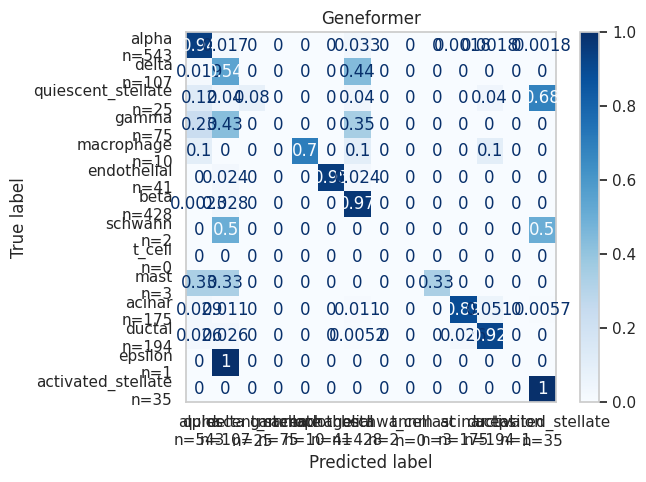

In [14]:
cc.plot_conf_mat(
        conf_mat_dict={"Geneformer": all_metrics_test["conf_matrix"]},
        output_directory=output_dir,
        output_prefix=output_prefix,
        #custom_class_order=["nf","hcm","dcm"],
)

In [17]:
cc.plot_predictions(
    predictions_file=f"{output_dir}/{output_prefix}_pred_dict.pkl",
    id_class_dict_file=f"{output_dir}/{output_prefix}_id_class_dict.pkl",
    title="disease",
    output_directory=output_dir,
    output_prefix=output_prefix,
    #custom_class_order=["nf","hcm","dcm"],
)

KeyError: 't_cell'

<Figure size 1500x1500 with 0 Axes>

In [18]:
all_metrics_test

{'conf_matrix':                     alpha  delta  quiescent_stellate  gamma  macrophage  \
 alpha                 513      9                   0      0           0   
 delta                   2     58                   0      0           0   
 quiescent_stellate      3      1                   2      0           0   
 gamma                  17     32                   0      0           0   
 macrophage              1      0                   0      0           7   
 endothelial             0      1                   0      0           0   
 beta                    1     12                   0      0           0   
 schwann                 0      1                   0      0           0   
 t_cell                  0      0                   0      0           0   
 mast                    1      1                   0      0           0   
 acinar                  5      2                   0      0           0   
 ductal                  5      5                   0      0           0 

In [14]:
!nvidia-smi

Fri May 31 09:09:44 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.76                 Driver Version: 550.76         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1080 Ti     Off |   00000000:04:00.0 Off |                  N/A |
| 26%   39C    P8             11W /  250W |    7069MiB /  11264MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# from geneformer import Classifier

# cc = Classifier(classifier="cell",
#                 cell_state_dict = {"state_key": "cell_type", "states": "all"},  
#                 forward_batch_size=64,
#                 nproc=8)

# all_metrics_test = cc.evaluate_saved_model(
#         model_directory='/part-vol-2/weaver-core/particle_transformer_quant/notebooks/Fun_Gen/output_directory_cell_class_pancreas/240602021923/240602_geneformer_cellClassifier_cm_classifier_test/ksplit1',
#         id_class_dict_file='/part-vol-2/weaver-core/particle_transformer_quant/notebooks/Fun_Gen/output_directory_cell_class_pancreas/240602021923/cm_classifier_test_id_class_dict.pkl',
#         test_data_file='/part-vol-2/weaver-core/particle_transformer_quant/notebooks/Fun_Gen/output_directory_cell_class_pancreas/240602021923/cm_classifier_test_labeled_test.dataset',
#         output_directory='/part-vol-2/weaver-core/particle_transformer_quant/notebooks/Fun_Gen/output_directory_cell_class_pancreas',
#         output_prefix='240602021923',
#     )

NameError: name 'Classifier' is not defined